# Measuring Max Drawdown
## Motivation: Another measure of risk other than volatility

- *Perspective*: Volatility is just deviation from the mean. Risk is the possibility of losing money.
- *Maximum Drawdown*: One another way of looking at risk.

> **Maximum Drawdown** : Maximum loss that you could have experienced if you bought the asset at its peak and sold it at the bottom
- Worst return of peak to trough that you could have experienced over the given time series

### How to take a return series and convert to a Drawdown
1. Take return series and convert to a wealth index.
    > **Wealth Index**: What would have happened if you'd bought an asset and kept it over time.
    
    > **Drawdown**: Decrease from peak to the trough at any given point in time. 
2. Compute the previous peaks.
    - At any point in time, keep track of what is the highest value experienced since inception.
    - When wealth rises, so does the peak. But when wealth falls, peak remains the same.
3. Compute drawdowns.
    - Drawdown: distance between previous peak and current position.
        - Distance is how much you feel you've lost. 
        - In line with known behavioural effects/ biases. 
        - Calculated as wealth value as a percentage of previous peak.
    - We can plot drawdowns to see how long it takes to recover from drawdowns.

> **Calmar Ratio**: Ratio of annualized return over the trailing 36 months to the _maximum drawdown_ over those trailing 36 months.

### Problems with drawdowns
1. Defined by two points, and so sensitive to outliers
2. Depend on frequency of observations => Daily/weekly drawdown that's very deep might almost completely disappear based on monthly data.
3. Other measures of extreme risk exist that are more robust. (e.g. VAR, CVAR)
    



In [16]:
def compound_int (principal, rate, n, t):
    return principal * (1+(rate/n))**(n*t)

## Computing Drawdowns

<AxesSubplot:>

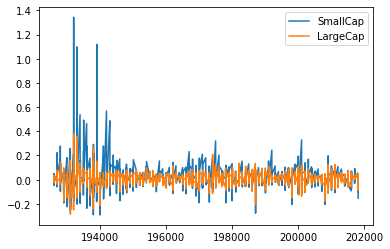

In [17]:
import pandas as pd
import numpy as np

me_m = pd.read_csv(".\data\Portfolios_Formed_on_ME_monthly_EW.csv", header=0, index_col=0, parse_dates=True, na_values=-99.99)
rets = me_m[['Lo 10', 'Hi 10']]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets/100
rets.head()
rets.plot.line()

Changing the index to time-series

In [18]:
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index
rets.head()

,SmallCap,LargeCap
1926-07-01,-0.0145,0.0329
1926-08-01,0.0512,0.0370
1926-09-01,0.0093,0.0067
1926-10-01,-0.0484,-0.0243
1926-11-01,-0.0078,0.0270


Index date is first of a month. The data pertains to the entire _period_. Can change it thus:

In [19]:
rets.index = rets.index.to_period("M")
rets.head()

,SmallCap,LargeCap
1926-07,-0.0145,0.0329
1926-08,0.0512,0.0370
1926-09,0.0093,0.0067
1926-10,-0.0484,-0.0243
1926-11,-0.0078,0.0270


Neat.  Filtering is even neater.

In [20]:
rets["1982"]

<ipython-input-20-3a242cb21248>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  rets["1982"]


,SmallCap,LargeCap
1982-01,-0.0052,-0.0193
1982-02,-0.0443,-0.0558
1982-03,-0.0104,-0.0140
1982-04,0.0535,0.0450
1982-05,-0.0175,-0.0406
1982-06,-0.0338,-0.0167
1982-07,-0.0148,-0.0193
1982-08,0.0362,0.1354
1982-09,0.0296,0.0058
1982-10,0.1228,0.1251


Even better! Can filter rows by years or months now.

In [25]:
rets["1982-01": "1983-06"]

,SmallCap,LargeCap
1982-01,-0.0052,-0.0193
1982-02,-0.0443,-0.0558
1982-03,-0.0104,-0.0140
1982-04,0.0535,0.0450
1982-05,-0.0175,-0.0406
1982-06,-0.0338,-0.0167
1982-07,-0.0148,-0.0193
1982-08,0.0362,0.1354
1982-09,0.0296,0.0058
1982-10,0.1228,0.1251


In [27]:
nov_mask = rets.index.map(lambda x: x.month) == 11
rets[nov_mask]

,SmallCap,LargeCap
1926-11,-0.0078,0.0270
1927-11,0.2242,0.0656
1928-11,0.1315,0.1462
1929-11,-0.1133,-0.1194
1930-11,-0.0463,-0.0258
...,...,...
2014-11,-0.0110,0.0256
2015-11,0.0109,0.0044
2016-11,0.0713,0.0431
2017-11,0.0340,0.0321


Nifty! Back to our scheduled programming now.

### Computing Drawdowns.
1. Compute wealth index.
2. Compute previous peaks.
3. Compute drawdowns: wealth value as a percentage of previous peak.


#### 1. Compute Wealth Index.

In [28]:
wealth_index = 1000*(1+rets["LargeCap"]).cumprod()
wealth_index.head()

1926-07    1032.900000
1926-08    1071.117300
1926-09    1078.293786
1926-10    1052.091247
1926-11    1080.497711
Freq: M, Name: LargeCap, dtype: float64

<AxesSubplot:>

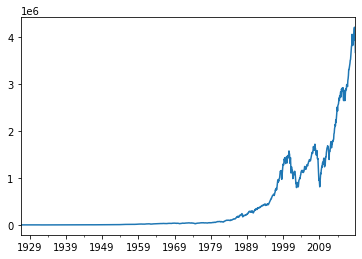

In [29]:
wealth_index.plot.line()

#### 2. Compute previous peaks.

<AxesSubplot:>

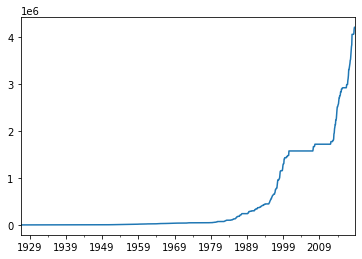

In [31]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot.line()

#### 3. Compute drawdowns.

<AxesSubplot:>

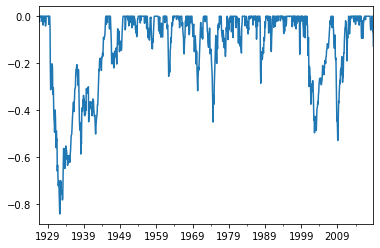

In [34]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()
# drawdown.tail()

- The decimation in 1929 was 80% - the largest ever. 
    - Will be interesting to see the figures in 2020. (This data goes only till 2018)
- You can use min() to find out the precise figure in 1929.
    

In [35]:
drawdown.min()

-0.8400375277943123

Or slice and then min. The following gives the minimum drawdown since 1975.

In [36]:
drawdown["1975":].min()

-0.5280945042309304

Or return the index of the min(), i.e., _when_ did the minimum drawdown occur.

In [41]:
print(drawdown.idxmin())
print(drawdown["1950":].idxmin())

1932-05
2009-02


Ah! The least drawdown was in _May 1932_, and not 1929. Also, the least drawdown since 1950 was in Feb 2009.

We can generalize this as a function.

In [47]:
def drawdown(return_series: pd.Series):
    """
    Takes a time-series of asset returns.
    Computes and returns a DataFrame that contains:
        1. The wealth index
        2. The previous peaks
        3. Percentage drawdowns
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns
        })
    

In [48]:
drawdown(rets["LargeCap"]).head()

,Wealth,Peaks,Drawdown
1926-07,1032.900000,1032.900000,0.0000
1926-08,1071.117300,1071.117300,0.0000
1926-09,1078.293786,1078.293786,0.0000
1926-10,1052.091247,1078.293786,-0.0243
1926-11,1080.497711,1080.497711,0.0000


This works! Let's do a graph.

<AxesSubplot:>

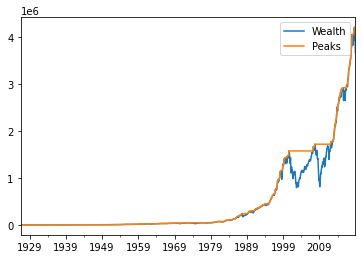

In [50]:
drawdown(rets["LargeCap"])[["Wealth", "Peaks"]].plot()

In [54]:
print((9300*13+29800+1000)*1.05)

159285.0


<AxesSubplot:>

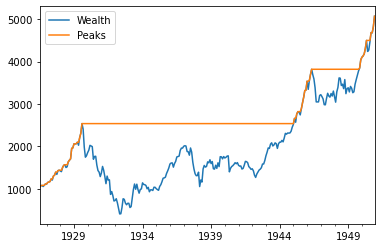

In [55]:
drawdown(rets[:"1950"]["LargeCap"])[["Wealth", "Peaks"]].plot()

In [56]:
drawdown(rets["LargeCap"])["Drawdown"].min()

-0.8400375277943123

In [57]:
drawdown(rets["SmallCap"])["Drawdown"].min()

-0.8330007793945303

Drawdowns in large and small caps are roughly the same amount. When did they happen? Let's use idxmin()

In [58]:
drawdown(rets["SmallCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [59]:
drawdown(rets["LargeCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

Yup, May 1932, when the Great Crash happened.

What about the period after that? What is the min and when did it happen?

In [73]:
print("-----Small Caps-----")
print("Least drawdown since 1940: {minDrawDown:.2%}".format(minDrawDown = drawdown(rets["1940":]["SmallCap"])["Drawdown"].min()))
print("The year-month this happened : {minDrawDown:}".format(minDrawDown = drawdown(rets["1940":]["SmallCap"])["Drawdown"].idxmin()))
print("Least drawdown since 1940: {minDrawDown:.2%}".format(minDrawDown = drawdown(rets["1975":]["SmallCap"])["Drawdown"].min()))
print("The year-month this happened : {minDrawDown:}".format(minDrawDown = drawdown(rets["1975":]["SmallCap"])["Drawdown"].idxmin()))
print("-----Large Caps-----")
print("Least drawdown since 1940: {minDrawDown:.2%}".format(minDrawDown = drawdown(rets["1940":]["LargeCap"])["Drawdown"].min()))
print("The year-month this happened : {minDrawDown:}".format(minDrawDown = drawdown(rets["1940":]["LargeCap"])["Drawdown"].idxmin()))
print("Least drawdown since 1940: {minDrawDown:.2%}".format(minDrawDown = drawdown(rets["1975":]["LargeCap"])["Drawdown"].min()))
print("The year-month this happened : {minDrawDown:}".format(minDrawDown = drawdown(rets["1975":]["LargeCap"])["Drawdown"].idxmin()))

-----Small Caps-----
Least drawdown since 1940: -70.01%
The year-month this happened : 1974-12
Least drawdown since 1940: -63.12%
The year-month this happened : 2009-02
-----Large Caps-----
Least drawdown since 1940: -52.81%
The year-month this happened : 2009-02
Least drawdown since 1940: -52.81%
The year-month this happened : 2009-02


Abstracting this out as functions.

In [76]:
def min_drawdown_amt(rets: pd.Series, cap: str, start_year: str):
    return drawdown(rets[start_year:][cap])["Drawdown"].min()
def min_drawdown_year(rets: pd.Series, cap: str, start_year: str):
    return drawdown(rets[start_year:][cap])["Drawdown"].idxmin()


In [84]:
start_year = "1940"
print("-----Small Caps-----")
caps = "SmallCap"
print("Least drawdown since 1940: {minDrawDown:.2%}".format(minDrawDown = min_drawdown_amt(rets,caps, start_year)))
print("Least drawdown since 1940: {minDrawDown:}".format(minDrawDown = min_drawdown_year(rets,caps, start_year)))

print("-----Large Caps-----")
caps = "LargeCap"
print("Least drawdown since 1940: {minDrawDown:.2%}".format(minDrawDown = min_drawdown_amt(rets,caps, start_year)))
print("Least drawdown since 1940: {minDrawDown:}".format(minDrawDown = min_drawdown_year(rets,caps, start_year)))
# print(min_drawdown_year(rets,caps,start_year))


-----Small Caps-----
Least drawdown since 1940: -70.01%
Least drawdown since 1940: 1974-12
-----Large Caps-----
Least drawdown since 1940: -52.81%
Least drawdown since 1940: 2009-02
